# Fruit Recognizer

The database used in this study is comprising of 44406 fruit images, which are collected in a period of 6 months. All the images are captured on a clear background with resolution of 320×258 pixels. For more information please see [here](https://www.kaggle.com/chrisfilo/fruit-recognition?select=Pear).

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.python import keras
import tensorflow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Activation
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.utils import to_categorical
import cv2


import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
import os

In [2]:
os.listdir('../data/Fruits')

['Apple', 'Pear', 'Carambola']

In [3]:
image_dir = '../data/Fruits/'

In [4]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [5]:
# Load the paths on the images
images = []
for f in os.listdir(image_dir):
    if "png" in os.listdir(image_dir+f)[0]:
        images += load_images_from_folder(image_dir+f,True,label = f)
    else: 
        for d in os.listdir(image_dir+f):
            images += load_images_from_folder(image_dir+f+"/"+d,True,label = f)

In [6]:
df = pd.DataFrame(images, columns = ["fruit", "path"])

In [7]:
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

In [8]:
df.head(2)

,fruit,path
0,Pear,../data/Fruits/Pear/Pear 54.png
1,Apple,../data/Fruits/Apple/Total Number of Apples/Ap...


In [9]:
# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

{'Apple': 0, 'Carambola': 1, 'Pear': 2}


In [10]:
df.head(2)

,fruit,path,label
0,Pear,../data/Fruits/Pear/Pear 54.png,2
1,Apple,../data/Fruits/Apple/Total Number of Apples/Ap...,0


In [11]:
df.fruit.value_counts()

Apple        11185
Pear          3013
Carambola     2080
Name: fruit, dtype: int64

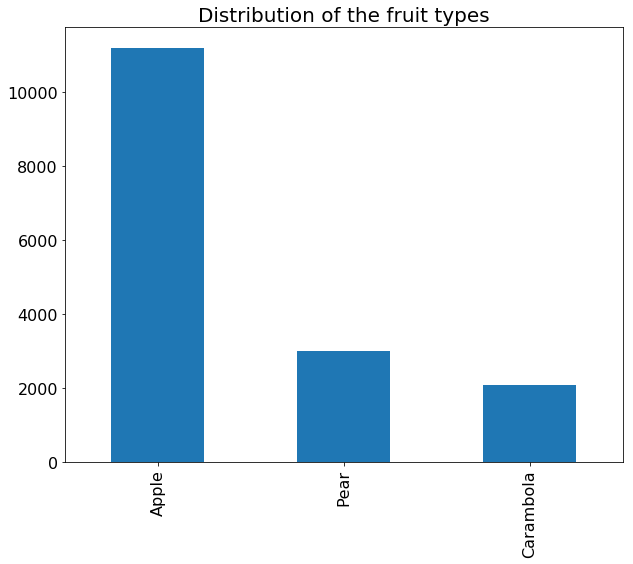

In [12]:
bar = df["fruit"].value_counts().plot.bar(figsize = (10,8))
plt.title("Distribution of the fruit types", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

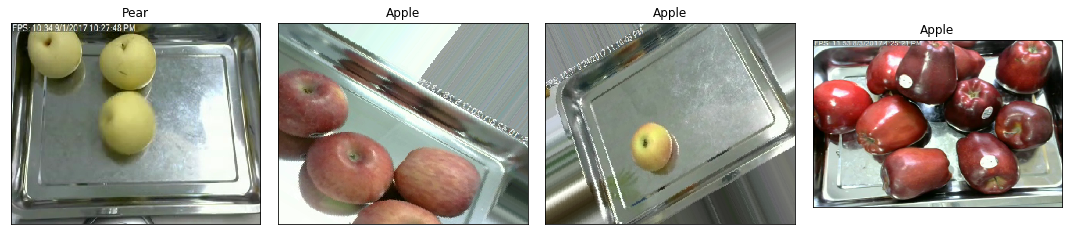

In [13]:
fig, axes = plt.subplots(1,4,figsize = (15,15),subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i])
plt.tight_layout()
plt.show()

### Build the model (CNN model)

In [14]:
def CNN_model(num_classes):
    
    Ksize = (3,3)
    shape = (150,150, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32,
                     kernel_size = Ksize,
                    strides = 2,
                    activation = 'relu',
                    input_shape = shape))
    model.add(Dropout(0.25)) #to combat overfitting
    
    model.add(Conv2D(filters = 64,
                     kernel_size = Ksize,
                    strides = 2,
                    activation = 'relu',
                    input_shape = shape))
    model.add(Dropout(0.25)) #to combat overfitting
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model   

In [15]:
def load_img(df):

    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [16]:
x, y = load_img(df.sample(1500))
y = to_categorical(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

In [18]:
model = CNN_model(num_classes=len(mapper_fruit_names))

In [19]:
model_history = model.fit(x,y,
                          batch_size=50,
                          epochs=20,
                          shuffle=True,
                          verbose=0,
                          validation_split = 0.2)

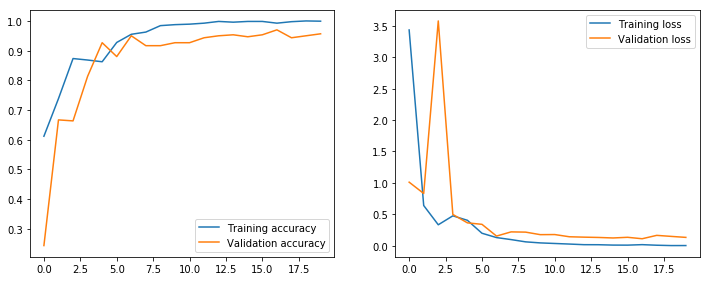

In [20]:
plt.subplots(1,2,figsize = (12,10))
plt.subplot(2,2,1)
plt.plot(model_history.history['accuracy'],label = 'Training accuracy')
plt.plot(model_history.history['val_accuracy'],label = 'Validation accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(model_history.history['loss'],label = 'Training loss')
plt.plot(model_history.history['val_loss'],label = 'Validation loss')
plt.legend()

In [21]:
model_history2 = model.fit(X_train,y_train,
                          batch_size=50,
                          epochs=20,
                          shuffle=True,
                          verbose=0,
                          validation_split = 0.2)

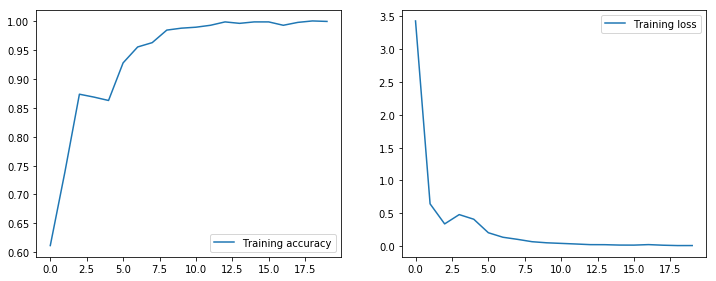

In [22]:
plt.subplots(1,2,figsize = (12,10))
plt.subplot(2,2,1)
plt.plot(model_history.history['accuracy'],label = 'Training accuracy')
plt.legend()
plt.subplot(2,2,2)
plt.plot(model_history.history['loss'],label = 'Training loss')
plt.legend()

### Prediction

In [23]:
preds = model.predict(X_test)

In [24]:
y_pred_classes = np.argmax(preds,axis = 1) 

In [25]:
y_real = np.argmax(y_test, axis = 1)

In [26]:
confusion_mtx = confusion_matrix(y_real, y_pred_classes)

In [27]:
print("confusion matrix:")
print(confusion_mtx)

confusion matrix:
[[189   0   3]
 [  0  41   1]
 [  4   0  62]]


In [28]:
print("classification_report:")
print(classification_report(y_real,y_pred_classes))

classification_report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       192
           1       1.00      0.98      0.99        42
           2       0.94      0.94      0.94        66

   micro avg       0.97      0.97      0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [29]:
print("Accuracy:", accuracy_score(y_real,y_pred_classes))

Accuracy: 0.9733333333333334


Thanks to [databeru](https://www.kaggle.com/databeru).